## <center>Chicago Crime Forecasting (2012-2017)
### <center>Anil Abraham 2023

#### <center>The goal of this project is to use machine learning techniques to forecast crime in Chicago. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/locations.

### Brief explanation of each column:
<ul>
<li>Unnamed: 0  - No idea what this is</li>
<li>ID - Unique crime identifier</li>
<li>Case Number - Unique case number recorded by Chicago PD</li>
<li>Date - Estimate Of when incident occured</li>
<li>IUCR - Illinois Uniform Crime Reporting code</li>
<li>Primary Type  - Primary description of IUCR code</li>
<li>Description - Secondary description of IUCR code</li>
<li>Location Description - Description of where incident occured</li>
<li>Arrest - Whether an arrest was made or not</li>
<li>Domestic - Whether incident was domestic-related or not</li>
<li>Beat - Smallest police geographic area</li>
<li>Block/District/Ward/Community Area/X Coordinate/Y Coordinate/Latitude/Longitude/Location - Location</li>
<li>FBI Code - Classification of crime according to the FBI's National Incident-Based Reporting System (NIBRS)</li>
<li>Year - Year that incident occured</li>
<li>Updated On - Date and time incident was last updated</li>
</ul>



### <u>Importing libraries</u>

In [59]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

### Loading dataset

In [60]:
df = pd.read_csv('chicago.csv') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

Unnamed: 0
ID
Case Number
Date
Block
IUCR
Primary Type
Description
Location Description
Arrest
Domestic
Beat
District
Ward
Community Area
FBI Code
X Coordinate
Y Coordinate
Year
Updated On
Latitude
Longitude
Location


(1456714, 23)

### <u>Data preprocessing</u>

#### Only certain columns are of interest to us, so let's drop the rest.

In [61]:
df.drop(['Unnamed: 0', 'Case Number','IUCR','Updated On', 'FBI Code', 'Beat','Ward','Community Area', 'Location'
         , 'X Coordinate', 'Y Coordinate', 'District', 'Year'], inplace=True, axis=1)

#### Check for null values

In [62]:
print(f'Before replacing nulls:\n{df.isna().sum()}\n')
df['Location Description'].fillna('Unknown', inplace=True)
print(f'After replacing nulls:\n{df.isna().sum()}')

Before replacing nulls:
ID                          0
Date                        0
Block                       0
Primary Type                0
Description                 0
Location Description     1658
Arrest                      0
Domestic                    0
Latitude                37083
Longitude               37083
dtype: int64

After replacing nulls:
ID                          0
Date                        0
Block                       0
Primary Type                0
Description                 0
Location Description        0
Arrest                      0
Domestic                    0
Latitude                37083
Longitude               37083
dtype: int64


#### Check for duplicates

In [63]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
0

After checking for duplicates
0


#### Convert Date to pandas datetime object, and covert the index to DatetimeIndex

In [64]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
# df['Month'] = df['Date'].dt.month
# df['Hour'] = df['Date'].dt.hour

df.index = pd.DatetimeIndex(df['Date'])
df.drop(['Date'], axis=1, inplace=True)

#### There are many unique categories, over 300 for description. Let's keep the most occuring categories and bin the rest as 'OTHER'

In [65]:
df.loc[df['Primary Type'].isin(df['Primary Type'].value_counts()[20:].index), ('Primary Type')] = 'OTHER'
df.loc[df['Description'].isin(df['Description'].value_counts()[20:].index), ('Description')] = 'OTHER'
df.loc[df['Location Description'].isin(df['Location Description'].value_counts()[20:].index), ('Location Description')] = 'OTHER'

#### Convert to categorical

In [66]:
# df['Primary Type'] = pd.Categorical(df['Primary Type'])
# df['Description'] = pd.Categorical(df['Description'])
# df['Location Description'] = pd.Categorical(df['Location Description'])

#### What datatypes are we working with?

In [67]:
df.dtypes

ID                        int64
Block                    object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Latitude                float64
Longitude               float64
dtype: object

#### Let's take a look at the first 5 and last 5 rows of the dataset

In [68]:
pd.concat([df.sort_index().head(5), df.sort_index(ascending=False).head(5)])

,ID,Block,Primary Type,Description,Location Description,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,,
2012-01-01 00:00:00,9055356,057XX N WEST CIRCLE AVE,THEFT,OTHER,STREET,False,False,41.985841,-87.804712
2012-01-01 00:00:00,8911136,040XX W 26TH ST,DECEPTIVE PRACTICE,OTHER,OTHER,False,False,41.844246,-87.725245
2012-01-01 00:00:00,10728377,032XX W WABANSIA AVE,DECEPTIVE PRACTICE,OTHER,RESIDENCE,False,False,NaN,NaN
2012-01-01 00:00:00,8422774,044XX W MADISON ST,THEFT,$500 AND UNDER,BAR OR TAVERN,False,False,41.880600,-87.736438
2012-01-01 00:00:00,10300803,067XX S RIDGELAND AVE,OFFENSE INVOLVING CHILDREN,OTHER,RESIDENCE,False,True,NaN,NaN
2017-01-18 23:49:00,10820691,034XX W DICKENS AVE,ROBBERY,ARMED: HANDGUN,ALLEY,False,False,NaN,NaN
2017-01-18 23:45:00,10820646,004XX N HOMAN AVE,WEAPONS VIOLATION,OTHER,SIDEWALK,True,False,NaN,NaN
2017-01-18 23:40:00,10821699,010XX W WILSON AVE,ROBBERY,ARMED: HANDGUN,STREET,False,False,NaN,NaN
2017-01-18 23:35:00,10820662,028XX W SHAKESPEARE AVE,ROBBERY,OTHER,ALLEY,False,False,NaN,NaN


### EDA

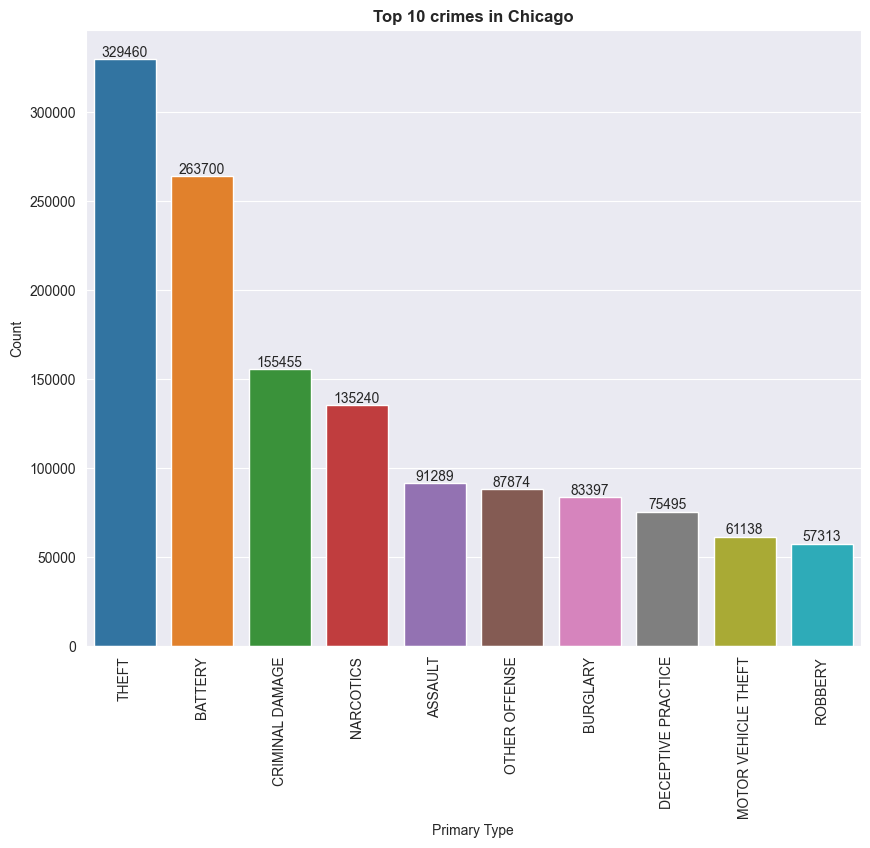

In [69]:
plt.figure(figsize=(10,8))
topcrimes = df['Primary Type'].value_counts()[:10]
ax = sns.barplot(x=topcrimes.index, y=topcrimes.values)
for i in ax.containers:
    ax.bar_label(i,)
    
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.title('Top 10 crimes in Chicago', weight='bold')
plt.xticks(rotation=90)
plt.show()

<Figure size 1900x1000 with 0 Axes>

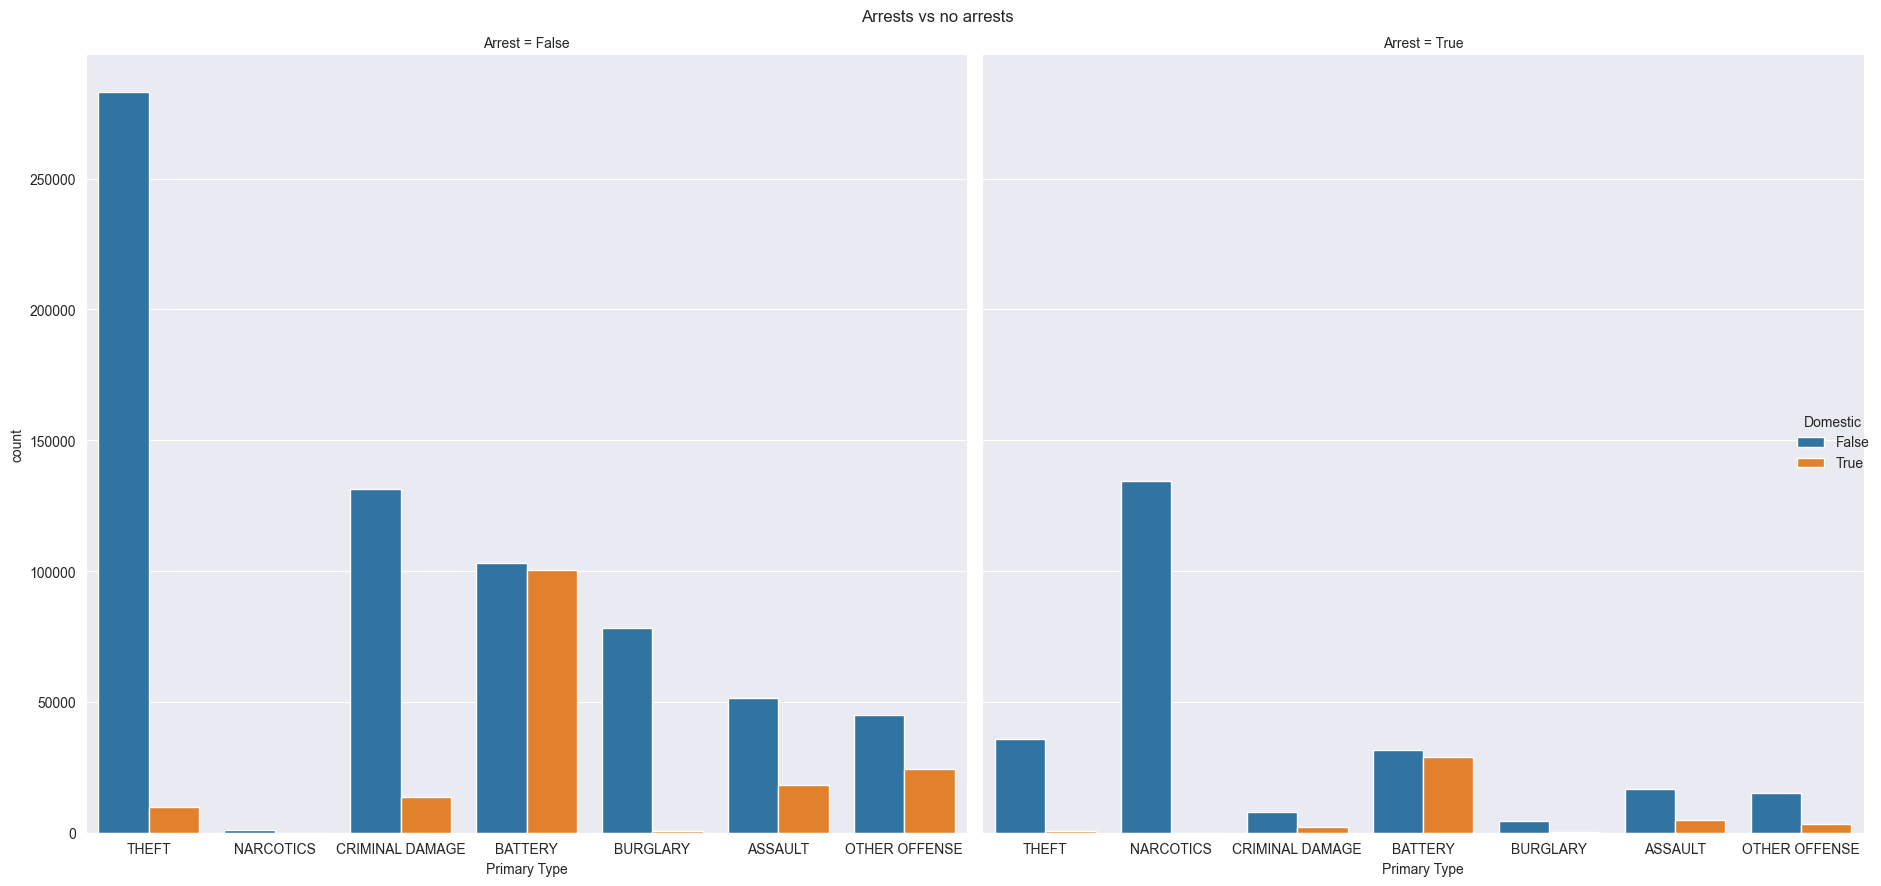

In [70]:
plt.figure(figsize=(19,10))
topcrimes = df['Primary Type'].value_counts()[:7]
df_grouped = df.loc[df['Primary Type'].isin(topcrimes.index)].groupby(['Arrest', 'Domestic', 'Primary Type']).size().reset_index(name='count').sort_values('count', ascending=False)
sns.catplot(df_grouped, x='Primary Type', y='count', hue='Domestic', kind='bar', height=9, col='Arrest')

plt.suptitle('Arrests vs no arrests')
plt.tight_layout()
plt.show()

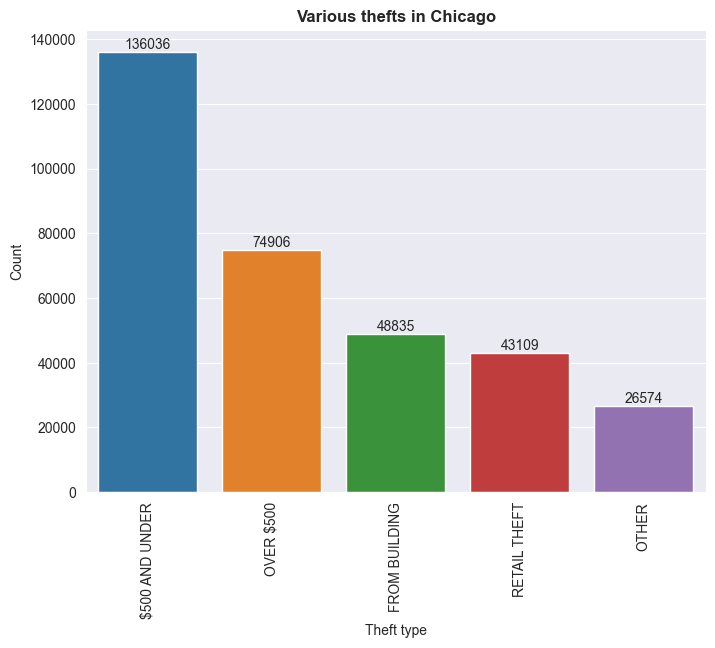

In [71]:
topthefts = df[df['Primary Type'] == 'THEFT']['Description'].value_counts()[:10]
plt.figure(figsize=(8,6))
ax = sns.barplot(x=topthefts.index, y=topthefts.values)
for i in ax.containers:
    ax.bar_label(i,)

plt.xlabel('Theft type')
plt.ylabel('Count')
plt.title('Various thefts in Chicago', weight='bold')
plt.xticks(rotation=90)
plt.show()

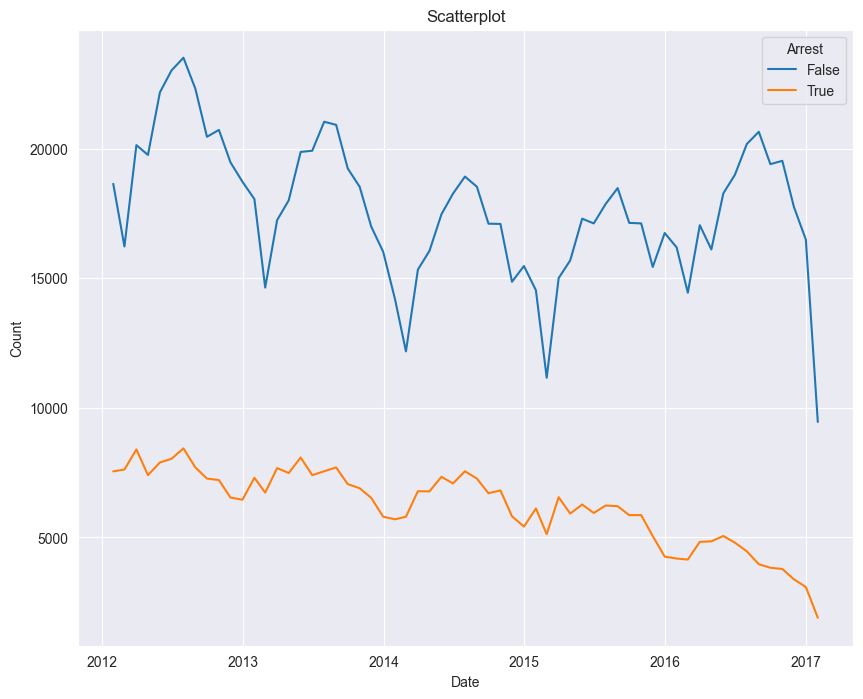

In [72]:
plt.figure(figsize=(10,8))
df_day_noarrest = df.loc[~df['Arrest']].resample('M').size().to_frame(name='count')
df_day_arrest = df.loc[df['Arrest']].resample('M').size().to_frame(name='count')

df_day_noarrest['Arrest'] = False
df_day_arrest['Arrest'] = True

df_merge = pd.concat([df_day_noarrest, df_day_arrest])

sns.lineplot(df_merge, x=df_merge.index, y='count', hue='Arrest')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Scatterplot')
plt.show()

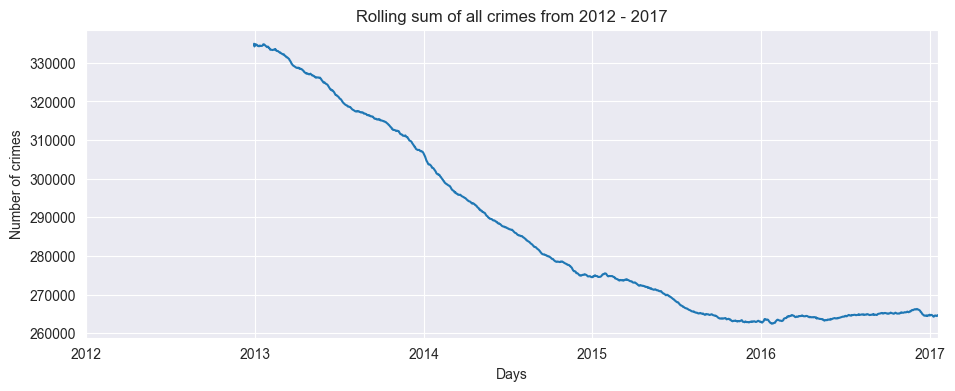

In [73]:
plt.figure(figsize=(11,4))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2012 - 2017')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

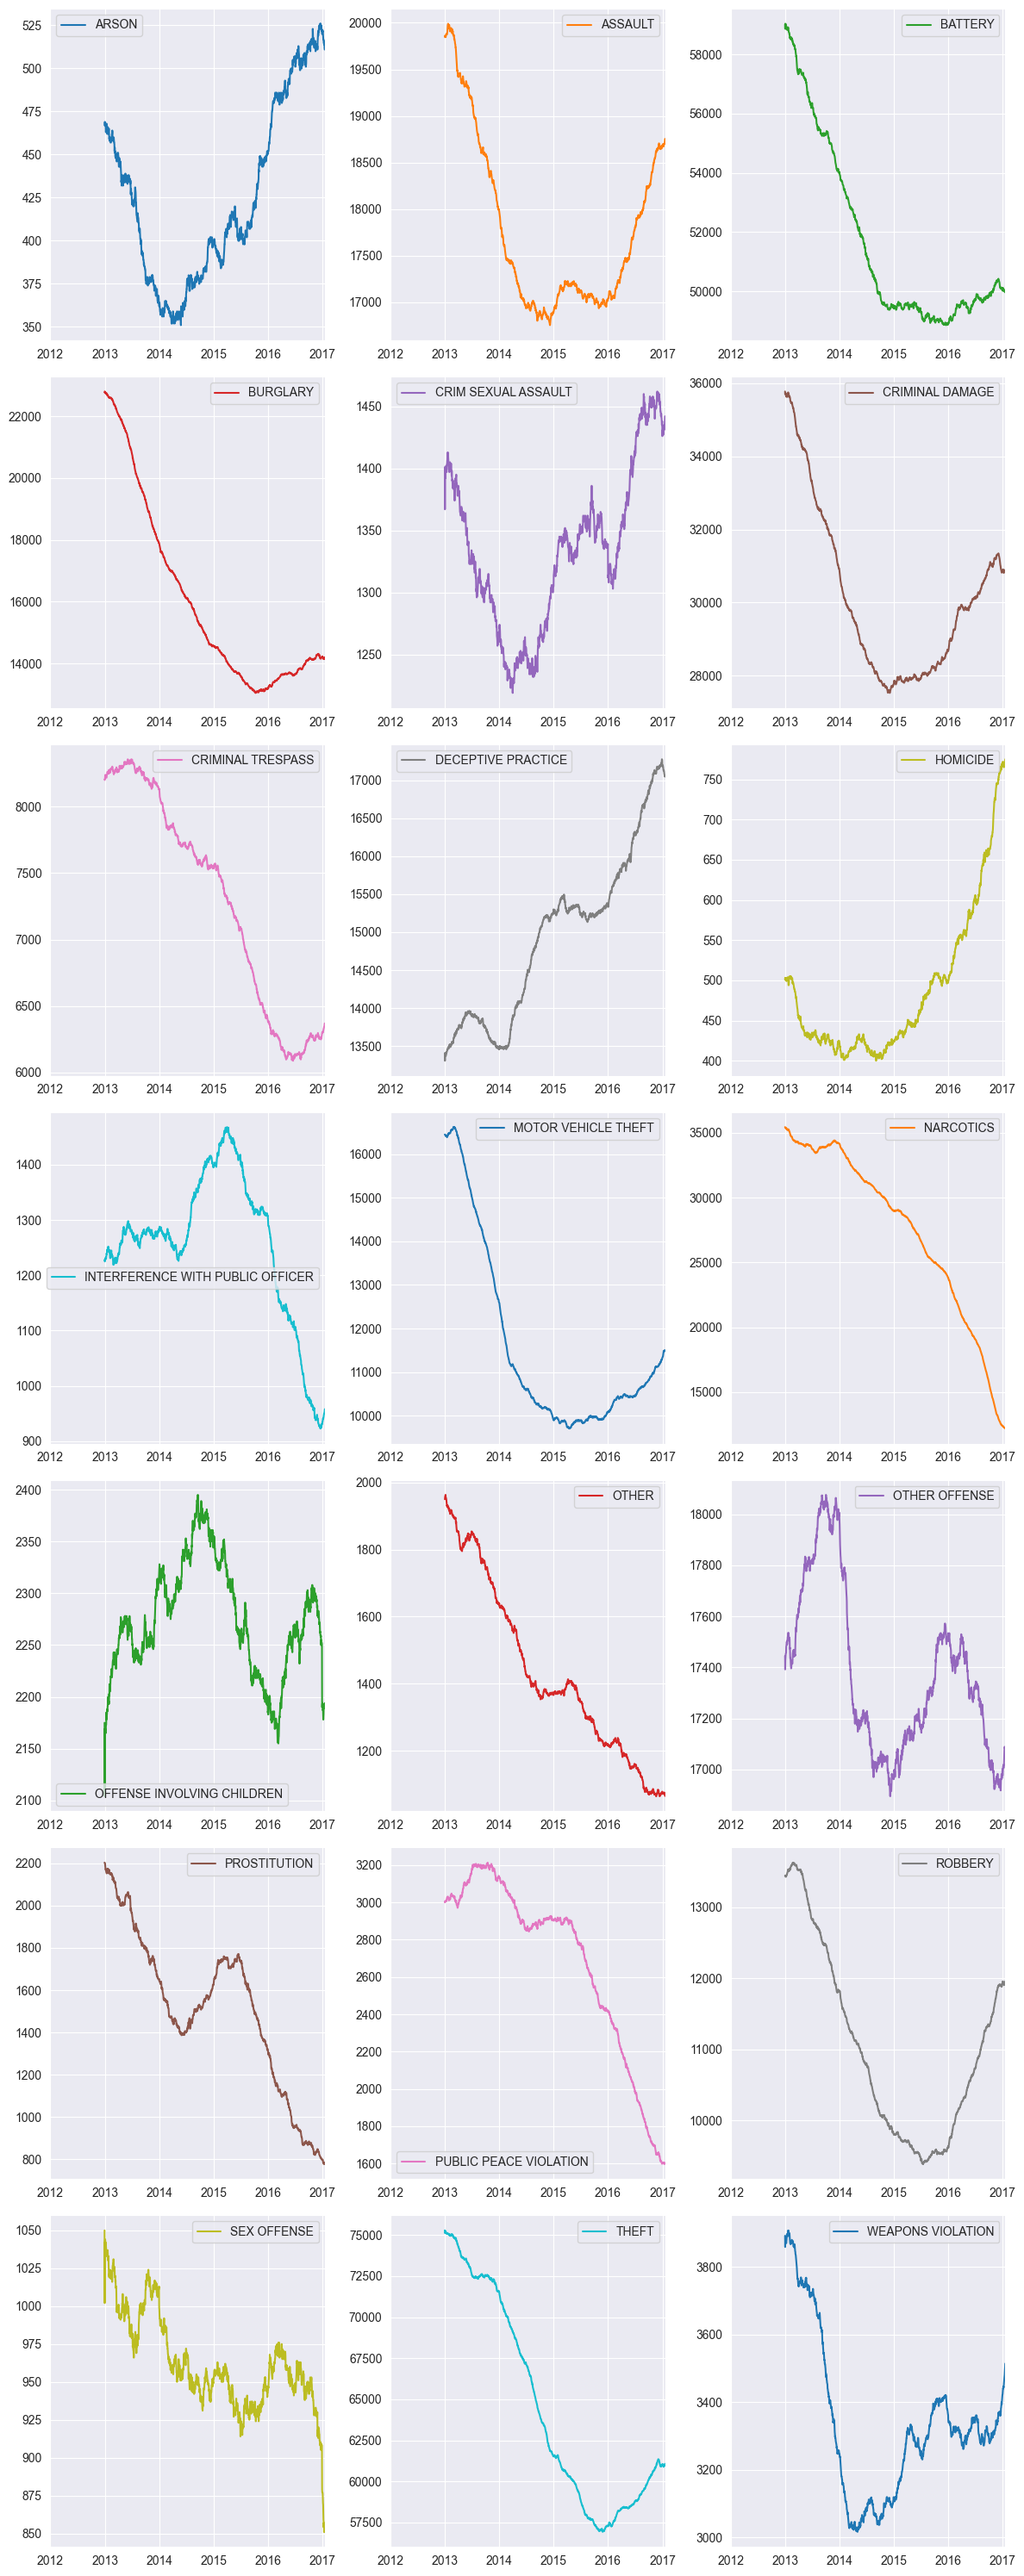

In [74]:
crimes_count_date = df.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=df.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)
plt.tight_layout()

In [76]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
heatmap = df.copy()
heatmap["Latitude"] = to_bin(df["Latitude"])
heatmap["Longitude"] = to_bin(df["Longitude"])
heatmap = heatmap.groupby(["Latitude", "Longitude"]).count()['ID'].reset_index(name='Count')
heatmap
#heatmap = heatmap[heatmap["STREET"] != "Unknown"] #The heatmap will list the Unknown location as a hotspot as there are a large number of unknown locations, therefore we remove this from visualisation.

,Latitude,Longitude,Count
0,36.61,-91.69,77
1,41.64,-87.62,245
2,41.64,-87.61,5
3,41.64,-87.60,1
4,41.64,-87.58,10
...,...,...,...
722,42.01,-87.69,2796
723,42.01,-87.68,4797
724,42.01,-87.67,2943
725,42.02,-87.68,1449


In [77]:
fig = px.scatter_mapbox(heatmap, lat="Latitude", lon="Longitude",
                    zoom=9.7, height=700, size_max=30, color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'],color="Count", hover_data=["Count"], size='Count')
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### <u>Machine Learning</u>

#### Import

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier

#### Data aquisition and categorical encoding

In [ ]:
null_mask = np.where(~df['Lat'].isnull())[0]

X = df.loc[null_mask, ('Lat', 'Long', 'HOUR', 'DAY_OF_WEEK')]
y = df.iloc[null_mask, 12]

ce.TargetEncoder(return_df=True, cols=['DAY_OF_WEEK']).fit_transform(X, y)


#### Sampling/split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Algorithm training

In [ ]:
def modelEvaluation(clf, encoder, scoring):
    cv = KFold(n_splits=5)
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"])
    for i in range(len(clf)):  
        start = process_time()  
        name = clf[i].__class__.__name__
        model = make_pipeline(encoder[i], StandardScaler(), clf[i]) if name == 'KNeighborsClassifier' else make_pipeline(encoder[i], clf[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        avg = round(cv_score.mean()*100, 2)
        std = round(cv_score.std()*100,2)
        accuracy = round(accuracy_score(y_test, y_pred)*100,2)
        precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
        recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
        f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
        print(f"{name} {avg}% std: {std} test: {accuracy}")
        print(f"{name} accuracy score: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
        end = process_time()
        print(f"Time taken: {end-start}s\n")
        results = pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})])

    return results.reset_index(drop=True)
  
clf = [RandomForestClassifier(n_jobs=-1, random_state=42),
       DecisionTreeClassifier(random_state=42), 
       CatBoostClassifier(random_state=42, silent=True),
       AdaBoostClassifier(random_state=42),
       GaussianNB()
       #KNeighborsClassifier()
       ]
encoders = [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            #OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            ]

#### Cross Validation & Results

In [ ]:
d = modelEvaluation(clf, encoders, 'f1_weighted')

In [ ]:
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

## <center><b>Thanks for reading!</b>